<a href="https://colab.research.google.com/github/Aditya-y9/ApnaMakaan-Aditya-s-rough-fork/blob/main/PostProcessingDEV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# square plot dims
room_positions = [{'name': 'Living Room', 'position': (48, 52), 'size': (349, 192)}, {'name': 'Bedroom1', 'position': (397, 52), 'size': (350, 192)}, {'name': 'Bedroom2', 'position': (48, 266), 'size': (219, 294)}, {'name': 'Passage', 'position': (346, 244), 'size': (156, 88)}, {'name': 'Kitchen', 'position': (503, 245), 'size': (197, 315)}, {'name': 'Washroom', 'position': (267, 264), 'size': (78, 142)}]

In [19]:
# pentagon plot dims
room_positions2 = [
{'name': 'Living Room', 'position': (216, 196), 'size': (143, 102)},
{'name': 'Bedroom1', 'position': (417, 207), 'size': (165, 92)},
{'name': 'Passage', 'position': (359, 185), 'size': (58, 113)},
{'name': 'Kitchen', 'position': (369, 299), 'size': (106, 170)},
{'name': 'Washroom', 'position': (262, 298), 'size': (107, 171)}
]

In [16]:
path = "/content/test_plot_6.png"
binary_plot = floorArray(path)

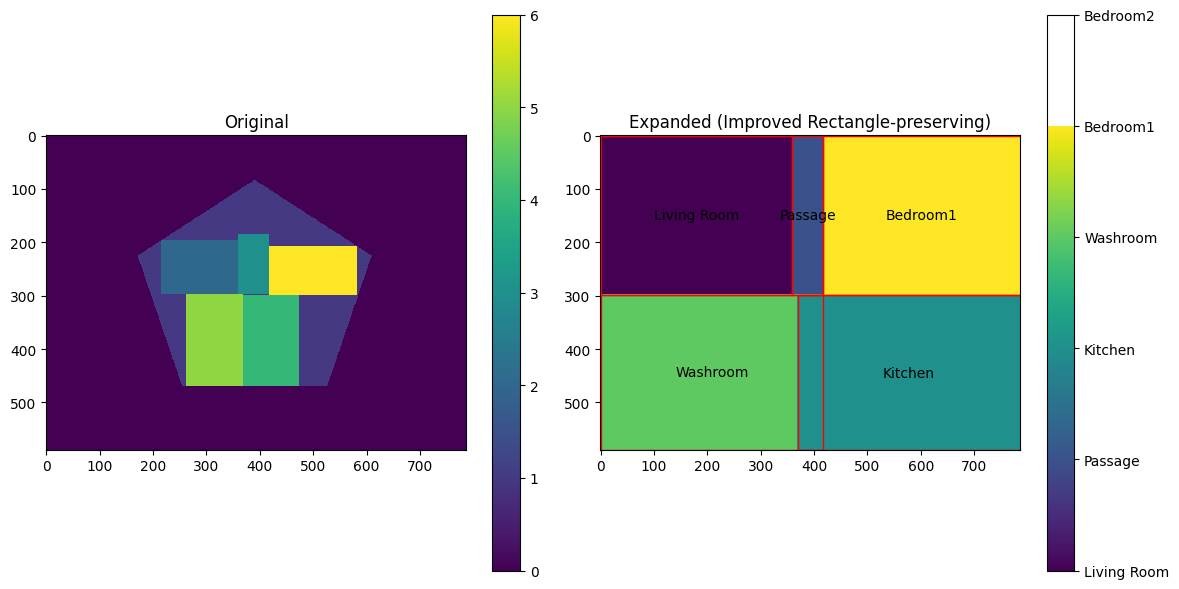

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, box
from matplotlib.patches import Rectangle

def expand_rooms_rectangle_preserving(binary_plot, room_positions, room_type_to_number):
    height, width = binary_plot.shape
    plot_polygon = Polygon([(0, 0), (0, height), (width, height), (width, 0)])

    expanded_rooms = []
    for room in room_positions:
        x, y = room['position']
        w, h = room['size']
        room_num = room_type_to_number[room['name']]
        expanded_rooms.append({
            'polygon': box(x, y, x+w, y+h),
            'number': room_num,
            'name': room['name']
        })

    # Custom sorting order
    room_order = ['living room', 'bedroom', 'kitchen', 'washroom']
    expanded_rooms.sort(key=lambda r: (room_order.index(r['name']) if r['name'] in room_order else len(room_order), -r['polygon'].area))

    for i, room in enumerate(expanded_rooms):
        while True:
            expanded = False
            for direction in ['right', 'left', 'down', 'up']:
                new_polygon = expand_in_direction(room['polygon'], direction)
                if new_polygon.within(plot_polygon) and all(not new_polygon.overlaps(other['polygon']) for j, other in enumerate(expanded_rooms) if i != j):
                    room['polygon'] = new_polygon
                    expanded = True
                    break
            if not expanded:
                break

    remaining_space = plot_polygon
    for room in expanded_rooms:
        remaining_space = remaining_space.difference(room['polygon'])

    if not remaining_space.is_empty:
        for part in remaining_space.geoms if hasattr(remaining_space, 'geoms') else [remaining_space]:
            closest_room = min(expanded_rooms, key=lambda r: r['polygon'].distance(part))
            closest_room['polygon'] = closest_room['polygon'].union(part)

    result = np.zeros_like(binary_plot)
    for room in expanded_rooms:
        x, y, w, h = room['polygon'].bounds
        x, y, w, h = map(int, (x, y, w, h))
        result[y:h, x:w] = room['number']

    return result, expanded_rooms

def expand_in_direction(polygon, direction):
    minx, miny, maxx, maxy = polygon.bounds
    if direction == 'right':
        return box(minx, miny, maxx + 1, maxy)
    elif direction == 'left':
        return box(minx - 1, miny, maxx, maxy)
    elif direction == 'down':
        return box(minx, miny, maxx, maxy + 1)
    elif direction == 'up':
        return box(minx, miny - 1, maxx, maxy)


expanded_array, expanded_rooms = expand_rooms_rectangle_preserving(binary_plot, room_positions, room_type_to_number)

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(binary_plot, interpolation='nearest')
plt.title("Original")
plt.colorbar()

plt.subplot(122)
plt.imshow(expanded_array, interpolation='nearest')
plt.title("Expanded (Improved Rectangle-preserving)")
cbar = plt.colorbar()

# Add room names to the plot
for room in expanded_rooms:
    minx, miny, maxx, maxy = room['polygon'].bounds
    rect = Rectangle((minx, miny), maxx-minx, maxy-miny, fill=False, edgecolor='red')
    plt.gca().add_patch(rect)
    plt.text((minx+maxx)/2, (miny+maxy)/2, room['name'], ha='center', va='center')

# Update colorbar ticks with room names
cbar.set_ticks(list(room_type_to_number.values()))
cbar.set_ticklabels(list(room_type_to_number.keys()))

plt.tight_layout()
plt.show()

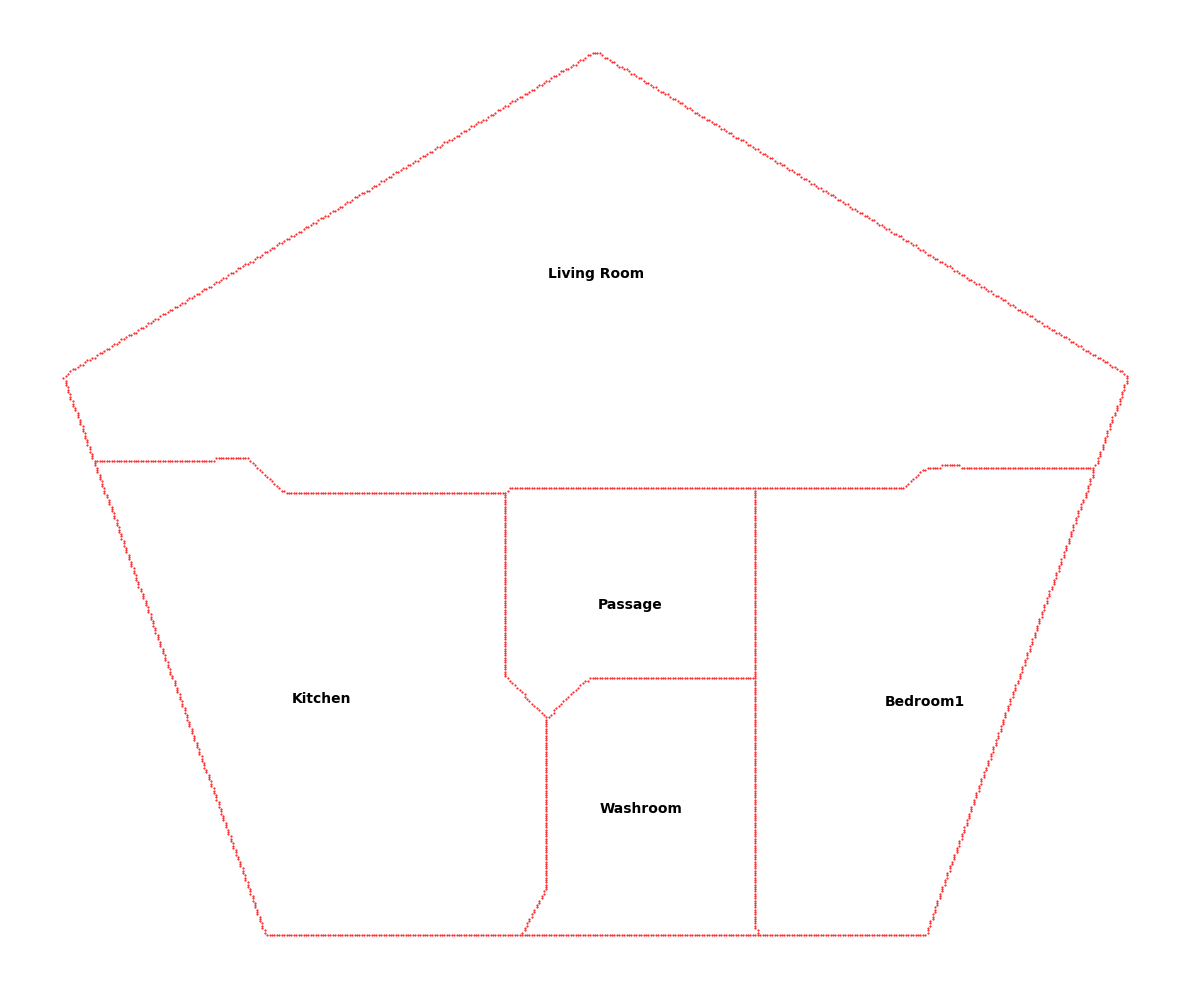

In [38]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.ndimage import measurements
from scipy.spatial.distance import euclidean as euclidean_distance
from pix_array import floorArray
from scipy.ndimage import binary_dilation, generate_binary_structure

# Load the binary plot (floor array)
path = "/content/test_plot.png"
binary_plot = floorArray(path)

room_positions3=[
    {'name': 'Living Room', 'position': (264, 165), 'size': (253, 110)},
    {'name': 'Passage', 'position': (354, 275), 'size': (103, 83)},
    {'name': 'Kitchen', 'position': (248, 278), 'size': (106, 170)},
    {'name': 'Washroom', 'position': (388, 358), 'size': (69, 111)},
    {'name': 'Bedroom1', 'position': (457, 275), 'size': (70, 192)}
]

room_positions2 = [
{'name': 'Living Room', 'position': (216, 196), 'size': (143, 102)},
{'name': 'Bedroom1', 'position': (417, 207), 'size': (165, 92)},
{'name': 'Passage', 'position': (359, 185), 'size': (58, 113)},
{'name': 'Kitchen', 'position': (369, 299), 'size': (106, 170)},
{'name': 'Washroom', 'position': (262, 298), 'size': (107, 171)}
]


room_positions = room_positions3


room_type_to_number = {
    "Living Room": 2,
    "Passage": 3,
    "Kitchen": 4,
    "Washroom": 5,
    "Bedroom1": 6,
    "Bedroom2": 7
}


def calculate_centroids(room_positions):
    centroids = []
    for room in room_positions:
        name = room['name']
        min_x, min_y = room['position']
        size_x, size_y = room['size']
        centroid_x = min_x + size_x / 2
        centroid_y = min_y + size_y / 2
        centroids.append({'name': name, 'centroid': (centroid_y, centroid_x)})
    return centroids


centroids = calculate_centroids(room_positions)


def euclidean_distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)


def update_plot_with_rooms(plot, room_positions, room_type_to_number):
    for room in room_positions:
        room_name = room['name']
        number = room_type_to_number[room_name]
        x, y = map(int, room['position'])
        length, breadth = map(int, room['size'])

        for i in range(y, y + breadth):
            for j in range(x, x + length):
                plot[i, j] = number


def expand_rooms_to_fill_voids(pixel_array):
    rows, cols = pixel_array.shape
    filled_array = pixel_array.copy()

    while True:
        changes_made = False
        new_filled_array = filled_array.copy()

        for r in range(rows):
            for c in range(cols):
                if filled_array[r, c] == 1:  # If the pixel is part of a void
                    # Check the nearest room vertically and horizontally
                    nearest_room_val = None
                    min_distance = float('inf')

                    # Check vertically
                    for vr in range(rows):
                        if filled_array[vr, c] > 1:
                            distance = abs(vr - r)
                            if distance < min_distance:
                                min_distance = distance
                                nearest_room_val = filled_array[vr, c]

                    # Check horizontally
                    for hc in range(cols):
                        if filled_array[r, hc] > 1:
                            distance = abs(hc - c)
                            if distance < min_distance:
                                min_distance = distance
                                nearest_room_val = filled_array[r, hc]

                    if nearest_room_val:
                        new_filled_array[r, c] = nearest_room_val
                        changes_made = True

        if not changes_made:
            break

        filled_array = new_filled_array

    return filled_array


def get_room_details(room_positions, room_name):
    for room in room_positions:
        if room['name'] == room_name:
            return room['position'], room['size']


def extend_boundaries(binary_plot, room_positions, room_type_to_number):
    x, y = binary_plot.shape
    filled_array = binary_plot.copy()

    # Define the priority order
    priority_order = ["Living Room", "Bedroom1", "Bedroom2", "Kitchen", "Washroom", "Passage"]

    # Expansion steps
    expansion_steps = 20  # Increase this for more expansion

    # Create a smaller structuring element for more controlled expansion
    struct = generate_binary_structure(2, 1)

    for step in range(expansion_steps):
        for room_name in priority_order:
            if room_name not in room_type_to_number:
                continue

            room_number = room_type_to_number[room_name]
            room_mask = filled_array == room_number

            # Expand only into empty spaces (value 1)
            expanded_mask = binary_dilation(room_mask, structure=struct)
            expanded_mask = np.logical_and(expanded_mask, filled_array == 1)

            # Preserve narrow passages
            if room_name == "Passage":
                # Find the original passage pixels
                original_passage = np.logical_and(binary_plot == room_number, expanded_mask)
                # Only expand into areas directly connected to the original passage
                expanded_mask = np.logical_and(expanded_mask, binary_dilation(original_passage, structure=struct))

            filled_array[expanded_mask] = room_number

        # Check if there's any space left to expand
        if np.sum(filled_array == 1) == 0:
            break

    return filled_array

def visualize_with_names(filled_plot, room_positions, room_type_to_number):
    fig, ax = plt.subplots(figsize=(12, 10))

    # Set background to white
    ax.set_facecolor('white')

    # Create a structural element for dilation
    struct = generate_binary_structure(2, 2)

    # Draw room boundaries
    for room_number in range(2, max(room_type_to_number.values()) + 1):
        room_mask = filled_plot == room_number
        dilated_mask = binary_dilation(room_mask, structure=struct)
        boundary = dilated_mask ^ room_mask
        y, x = np.where(boundary)
        ax.plot(x, y, 'r.', markersize=1)

    # Add room labels
    for room in room_positions:
        room_name = room['name']
        room_number = room_type_to_number[room_name]
        room_mask = filled_plot == room_number
        if np.any(room_mask):
            y, x = np.where(room_mask)
            center_y, center_x = (y.min() + y.max()) / 2, (x.min() + x.max()) / 2
            ax.text(center_x, center_y, room_name, ha='center', va='center', color='black', fontweight='bold')

    # Remove axes
    ax.axis('off')

    # Invert y-axis to match image coordinates
    ax.invert_yaxis()

    plt.tight_layout()
    plt.show()


def extend_boundaries(binary_plot, room_positions, room_type_to_number):
    x, y = binary_plot.shape
    filled_array = binary_plot.copy()

    # Define the priority order
    priority_order = ["Living Room", "Bedroom1", "Bedroom2", "Kitchen", "Washroom", "Passage"]

    # Expansion steps
    expansion_steps = 15  # Reduced for less aggressive expansion

    # Create a smaller structuring element for more controlled expansion
    struct = generate_binary_structure(2, 1)

    for step in range(expansion_steps):
        for room_name in priority_order:
            if room_name not in room_type_to_number:
                continue

            room_number = room_type_to_number[room_name]
            room_mask = filled_array == room_number

            # Expand only into empty spaces (value 1)
            expanded_mask = binary_dilation(room_mask, structure=struct)
            expanded_mask = np.logical_and(expanded_mask, filled_array == 1)

            filled_array[expanded_mask] = room_number

        # Check if there's any space left to expand
        if np.sum(filled_array == 1) == 0:
            break

    return filled_array

def smooth_boundaries(filled_plot):
    # Create a binary image of all boundaries
    boundaries = np.zeros_like(filled_plot, dtype=bool)
    for room_number in np.unique(filled_plot):
        if room_number == 1:  # Skip empty space
            continue
        room_mask = filled_plot == room_number
        room_boundary = binary_dilation(room_mask) ^ room_mask
        boundaries |= room_boundary

    # Skeletonize the boundaries
    smooth_boundaries = skeletonize(boundaries)

    return smooth_boundaries

def visualize_with_smooth_boundaries(filled_plot, room_positions, room_type_to_number):
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.set_facecolor('white')

    # Get smooth boundaries
    smooth_bounds = smooth_boundaries(filled_plot)

    # Plot smooth boundaries
    y, x = np.where(smooth_bounds)
    ax.plot(x, y, 'r.', markersize=1)

    # Add room labels
    for room in room_positions:
        room_name = room['name']
        room_number = room_type_to_number[room_name]
        room_mask = filled_plot == room_number
        if np.any(room_mask):
            y, x = np.where(room_mask)
            center_y, center_x = (y.min() + y.max()) / 2, (x.min() + x.max()) / 2
            ax.text(center_x, center_y, room_name, ha='center', va='center', color='black', fontweight='bold')

    ax.axis('off')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()
# Update the main code
update_plot_with_rooms(binary_plot, room_positions, room_type_to_number)
filled_plot = extend_boundaries(binary_plot, room_positions, room_type_to_number)
filled_plot = expand_rooms_to_fill_voids(filled_plot)

visualize_with_smooth_boundaries(filled_plot, room_positions, room_type_to_number)